In [1]:
import numpy as np
import h5py
import params
import arrayfire as af
import matplotlib.pyplot as pl
import cks.initialize as initialize
import cks.fdtd as fdtd
import cks.evolve as evolve
import time as timer
# from scipy.fftpack import fftfreq
af.set_backend("cpu")

% matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = False
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['savefig.dpi']     = 100

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
config = initialize.set(params)

In [4]:
def gauss1D(x, spread):
    return af.exp(-((x - 0.5)**2 )/(2*spread**2))

In [5]:
X = initialize.calculate_x(config)[:, :, 0, 0]
Y = initialize.calculate_y(config)[:, :, 0, 0]

In [6]:
left_boundary  = config.left_boundary
right_boundary = config.right_boundary
bot_boundary   = config.bot_boundary
top_boundary   = config.top_boundary

length_x = right_boundary - left_boundary
length_y = top_boundary - bot_boundary

N_x = config.N_x
N_y = config.N_y

N_ghost_x = config.N_ghost_x
N_ghost_y = config.N_ghost_y

In [7]:
dx = (length_x/(N_x - 1))
dy = (length_y/(N_y - 1))

dt = (dx/2)

final_time = 1
time       = np.arange(0, final_time, dt)

In [8]:
Ex = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Ey = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Ez = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Bx = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
By = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
Bz = af.data.constant(0, X.shape[0], X.shape[1], dtype=af.Dtype.f64)

In [9]:
# def fft_poisson(rho, dx, dy = None):
#     k_x = af.to_array(fftfreq(rho.shape[1], dx))
#     k_x = af.Array.as_type(k_x, af.Dtype.c64)
#     k_y = af.to_array(fftfreq(rho.shape[0], dy))
#     k_x = af.tile(af.reorder(k_x), rho.shape[0], 1)
#     k_y = af.tile(k_y, 1, rho.shape[1])
#     k_y = af.Array.as_type(k_y, af.Dtype.c64)

#     rho_hat       = af.fft2(rho)
#     potential_hat = af.constant(0, rho.shape[0], rho.shape[1], dtype=af.Dtype.c64)
    
#     potential_hat       = (1/(4 * np.pi**2 * (k_x*k_x + k_y*k_y))) * rho_hat
#     potential_hat[0, 0] = 0
    
#     E_x_hat = -1j * 2 * np.pi * (k_x) * potential_hat
#     E_y_hat = -1j * 2 * np.pi * (k_y) * potential_hat

#     E_x = af.ifft2(E_x_hat)
#     E_y = af.ifft2(E_y_hat)

#     af.eval(E_x, E_y)
#     return(E_x, E_y)

In [10]:
# rho = 0.01*af.cos(2*np.pi*X + 4*np.pi*Y)
# Ex_local, Ey_local = fft_poisson(rho[1:-2, 1:-2], dx, dy)

# Ex_local = af.join(0, Ex_local, Ex_local[0])
# Ex_local = af.join(1, Ex_local, Ex_local[:, 0])

# Ey_local = af.join(0, Ey_local, Ey_local[0])
# Ey_local = af.join(1, Ey_local, Ey_local[:, 0])

# Ex = af.constant(0, N_y + 2*N_ghost_y, N_x + 2*N_ghost_x, dtype=af.Dtype.c64)
# Ey = af.constant(0, N_y + 2*N_ghost_y, N_x + 2*N_ghost_x, dtype=af.Dtype.c64)

# Ex[N_ghost_y:-N_ghost_y, N_ghost_x:-N_ghost_x] = Ex_local
# Ex                                             = evolve.periodic_x(config, Ex)
# Ex                                             = evolve.periodic_y(config, Ex)

# Ey[N_ghost_y:-N_ghost_y, N_ghost_x:-N_ghost_x] = Ey_local
# Ey                                             = evolve.periodic_x(config, Ey)
# Ey                                             = evolve.periodic_y(config, Ey)

# Ex = af.real(Ex)
# Ey = af.real(Ey)

# pl.contourf(np.array(Ex))

Ex[1:-1, 1:-1] = gauss1D(Y[1:-1, 1:-1], 0.1)
Ey[1:-1, 1:-1] = gauss1D(X[1:-1, 1:-1], 0.1)

In [11]:
# Jz = af.data.constant(1, X.shape[0], X.shape[1], dtype=af.Dtype.f64)
# R  = af.sqrt((X - 20)**2 + (Y - 20)**2)
# Jz = 0.5*(af.tanh((R-0.35)/0.1) + af.tanh((0.65-R)/0.1))
# pl.contourf(np.array(X[1:-1, 1:-1]), np.array(Y[1:-1, 1:-1]), np.array(Jz[1:-1, 1:-1]), 100)
# pl.title('$J_z$')
# pl.xlabel('$x$')
# pl.ylabel('$y$')
# pl.colorbar()

# pl.plot(af.reorder(X[512]), af.reorder(Jz[512]))
# pl.ylabel(r'$J_z$')
# pl.xlabel('$x$')

In [12]:
Ex_initial = Ex.copy()
Ey_initial = Ey.copy()
Ez_initial = Ez.copy()
Bx_initial = Bx.copy()
By_initial = By.copy()
Bz_initial = Bz.copy()

Jx, Jy, Jz = 0, 0, 0

In [13]:
for time_index, t0 in enumerate(time):
    old1 = Ex[8, 12]
    old2 = Ey[8, 12]
    old3 = Bz[8, 12]
    print(time_index)        
    Bz, Ex, Ey = fdtd.mode2_fdtd(config, Bz, Ex, Ey, 0, 0, dt)
    print('Ex = ', af.sum(old1))
    print('Ey = ', af.sum(old2))
    print('Bz = ', af.sum(old3))
    timer.sleep(2)
    
#     div_E = af.convolve2_separable(af.Array([0, 1, 0]) ,af.Array([0, 1, -1]), Ex)*(1/dx) +\
#             af.convolve2_separable(af.Array([0, 1, -1]),af.Array([0, 1, 0]) , Ey)*(1/dy)
    
#     fig   = pl.figure()
      

#     fig.add_subplot(131, aspect = 'equal')
#     pl.contourf(np.array(Ez[::5, ::5]), 100)
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$E_z' + '(t=%.4f)$'%(t0 + dt))
    
# #     fig.add_subplot(222, aspect = 'equal')
# #     pl.contourf(np.array(Jz), 100)    
# #     pl.xticks([])
# #     pl.yticks([])
# #     pl.title('$J_z$' + '($t=%.4f$)'%(t0+dt))
    
#     fig.add_subplot(132, aspect = 'equal')
#     pl.contourf(np.array(Bx[::5, ::5]), 100)
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$B_x' + '(t=%.4f)$'%(t0 + dt))

#     fig.add_subplot(133, aspect = 'equal')
#     pl.contourf(np.array(By[::5, ::5]), 100)    
#     pl.xticks([])
#     pl.yticks([])
#     pl.title('$B_y' + '(t=%.4f)$'%(t0 + dt))
    
# #     pl.contourf(np.array(X[1:-1, 1:-1]), np.array(Y[1:-1, 1:-1]), np.array(Bz[1:-1, 1:-1]), 100)
# #     pl.xlabel('$x$')
# #     pl.ylabel('$y$')
# #     pl.colorbar()
# #     pl.title(r'$B_z$')

#     pl.savefig('images/' + "%04d"%time_index + '.png')
#     pl.close(fig)
#     pl.clf()

0
Ex =  0.023304586346960973
Ey =  0.34868372128377334
Bz =  0.0
1
Ex =  0.023304586346960973
Ey =  0.34868372128377334
Bz =  -0.0748659983634236
2
Ex =  0.0273302747861147
Ey =  0.358323658131324
Bz =  -0.1452440377710711
3
Ex =  0.03558203428157225
Ey =  0.3764653256649907
Bz =  -0.20681408525006614
4
Ex =  0.04842150234486971
Ey =  0.4009567851734848
Bz =  -0.2556134885804577
5
Ex =  0.06629580087814417
Ey =  0.42886785017004975
Bz =  -0.2882597466121429


KeyboardInterrupt: 

In [14]:
error_E_x = af.sum(af.abs(Ex[1:-1] - Ex_initial[1:-1]))/(X.shape[0] * X.shape[1])
error_E_y = af.sum(af.abs(Ey[1:-1] - Ey_initial[1:-1]))/(X.shape[0] * X.shape[1])
error_B_z = af.sum(af.abs(Bz[1:-1] - Bz_initial[1:-1]))/(X.shape[0] * X.shape[1])

In [15]:
print(error_E_x)
print(error_E_y)
print(error_B_z)

0.08472302406380879
0.07130313365804812
0.23116702368327377


In [16]:
N     = np.array([16, 32, 64, 128, 256])

error_B_x = np.array([0.016404315211801735, 0.007538214539509765, 0.0035662829189681408, \
                      0.0037983704324089534, 0.0019241780767072258
                     ]
                    )
error_B_y = np.array([0.0029627076807707937, 0.00028789773182735453, 2.0652815353209603e-05, \
                      3.109640951095606e-05, 3.690332968482948e-06
                     ]
                    )
error_E_z = np.array([0.017643673531186267, 0.004508667423970165, 0.0011128985837107947, \
                      0.0011389163396302786, 0.000286153415772662
                     ]
                    )

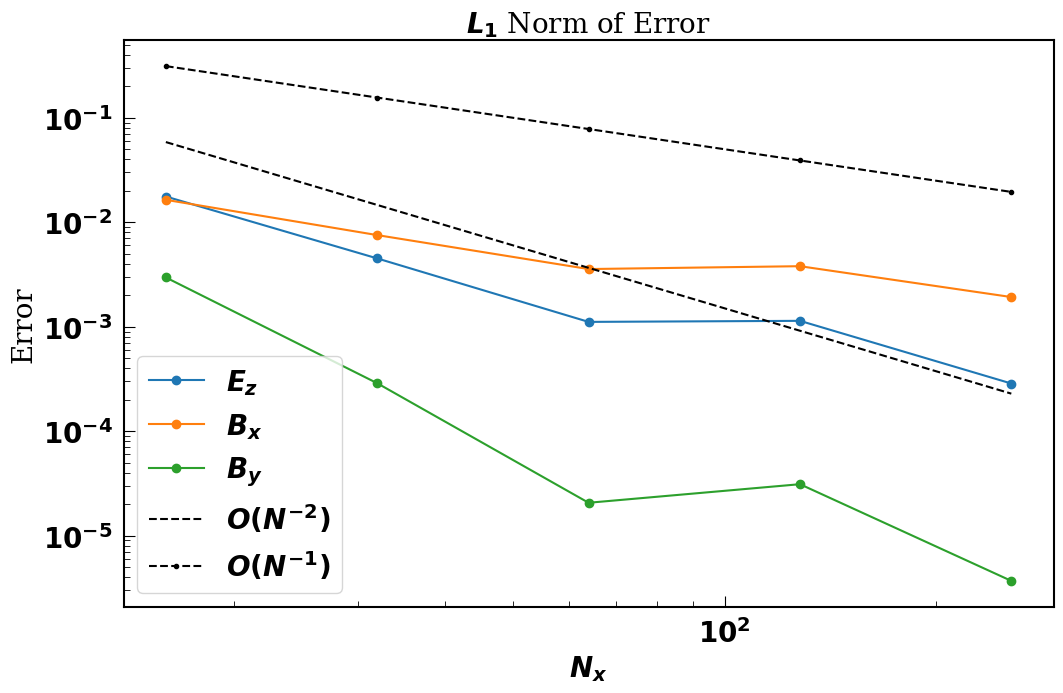

In [17]:
pl.loglog(N, error_E_z, '-o', label = '$E_z$')
pl.loglog(N, error_B_x, '-o', label = '$B_x$')
pl.loglog(N, error_B_y, '-o', label = '$B_y$')
pl.loglog(N, 15/N**2, '--', color = 'black', label = '$O(N^{-2})$')
pl.loglog(N, 5/N, '.--', color = 'black', label = '$O(N^{-1})$')
pl.legend()
pl.title('$L_1$ Norm of Error')
pl.xlabel('$N_x$')
pl.ylabel('Error')

In [18]:
print(Ey_initial[8, 12])

arrayfire.Array()
Type: double

[1 1 1 1]
    0.3487 



In [19]:
print(time)

[ 0.          0.01612903  0.03225806  0.0483871   0.06451613  0.08064516
  0.09677419  0.11290323  0.12903226  0.14516129  0.16129032  0.17741935
  0.19354839  0.20967742  0.22580645  0.24193548  0.25806452  0.27419355
  0.29032258  0.30645161  0.32258065  0.33870968  0.35483871  0.37096774
  0.38709677  0.40322581  0.41935484  0.43548387  0.4516129   0.46774194
  0.48387097  0.5         0.51612903  0.53225806  0.5483871   0.56451613
  0.58064516  0.59677419  0.61290323  0.62903226  0.64516129  0.66129032
  0.67741935  0.69354839  0.70967742  0.72580645  0.74193548  0.75806452
  0.77419355  0.79032258  0.80645161  0.82258065  0.83870968  0.85483871
  0.87096774  0.88709677  0.90322581  0.91935484  0.93548387  0.9516129
  0.96774194  0.98387097]
